# Measuring mass resolution

In this notebook I'll attempt to determine the mass resolution by fitting a resonance of known width with a Voigt profile.  The Voigt profile has two width parameters: one accounting for the width of the resonance (as in the Cauchy distribution), and another accounting for detector mass measurement resolution (a Gaussian).  This will first be carried out on simulation first.

In [11]:
# imports and some setup
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import sys, os

import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import Parameters

from nllfitter import Model, NLLFitter
import nllfitter.fit_tools as ft
import nllfitter.plot_tools as pt


/home/naodell/work/CMS/amumu


## 2-body decay
The simulated dataset has a X boson decaying to two muons.  The FWHM of the X was set to be 1.9 GeV.  Let's get our mass spectra,

In [12]:
# retrieve the mass spectrum and restrict to range (12, 70)
xlim = (12, 70) # restrict consideration to data the lies in this range
ntuple_dir = 'data/flatuples/mumu_2012'
data = pd.read_pickle(ntuple_dir + '/ntuple_fcnc.pkl')
data = data.query('{0[0]} < dilepton_b_mass < {0[1]}'.format(xlim))
mass = data.dilepton_b_mass.values

### Define the fit function

I will use the implementation suggested [here](http://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/) for the Voigt profile.  This is *pretty* much the same as the TMath implementation.

A large part of mass mismeasurement will result from non-detection of daughter particles from the b quark decay.  This will be inspected more closely in the future by comparing generator and reconstructed kinematics of the b jet.  So in addition to the effects of the inherent mass resolution of the muons and b jet, we will need to account for undetected energy.

The Voigt profile inherits the property of the the Cauchy distribution that it does not normalize on the range $(-\infty, \infty)$.  To address this, I will integrate over the fit range.


In [13]:
def pdf(x, a):
    #f = lambda z: ft.voigt(z, np.concatenate((a[:2], [a[2] + a[3]*z])))
    f = lambda z: ft.voigt(z, a)

    if isinstance(x, np.ndarray):
        #fx = np.apply_along_axis(f, 0, x)
        fx = np.array([f(xx) for xx in x])
    else:
        fx = f(x)
    norm = integrate.quad(f, xlim[0], xlim[1])[0]
    
    return fx/norm

### Set up and carry out fit

In [19]:
params = Parameters()
params.add_many(
                ('mu'     , 30. , True  , 20., 40. , None),
                ('gamma'  , 0.95 , False , 0.1  , 3.  , None),
                ('sigma0' , 1.  , True  , 0.1  , 2.  , None),
                #('sigma1' , 0.1  , True  , -10.  , 10.  , None),
               )
model = Model(pdf, params)
fitter = NLLFitter(model)
result = fitter.fit(mass, calculate_corr=True)

Fit finished with status: 0
[[Variables]]
    mu:       28.6531715 +/- 0.004747 (0.02%) (init= 30)
    gamma:    0.95 (fixed)
    sigma0:   0.18145432 +/- 0.017097 (9.42%) (init= 1)

[[Correlation matrix]]
[[ 1.     0.022 -0.04 ]
 [ 0.022  1.    -0.658]
 [-0.04  -0.658  1.   ]] 



### Make some plots

First, let's inspect the mass spectrum and determine visually how well the fit performs.

<IPython.core.display.Javascript object>


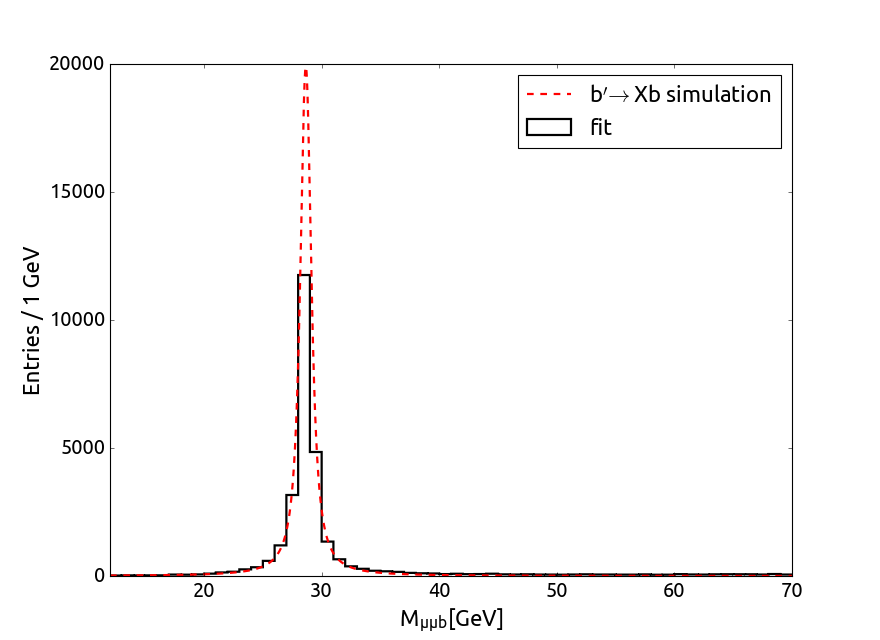

In [20]:
# prepare plot comparing data to fit results
pt.set_new_tdr()
plt.hist(mass, bins=58, range=(12, 70), histtype='step', linewidth=2., color='k')

x = np.linspace(xlim[0], xlim[1], 10000)
y = mass.size*(xlim[1] - xlim[0])*pdf(x, result.x)/50
plt.plot(x, y, 'r--', linewidth=2.)

plt.legend([r"$\sf b'\rightarrow Xb$ simulation", 'fit'])
plt.xlim(12, 70)
plt.xlabel('$\sf M_{\mu\mu b} [GeV]$')
plt.ylabel('Entries / 1 GeV')
plt.show()

Looks quite good!  

## 3-body decay 

In [ ]:
# plot the resolution as a function the mass
y = result.x[2] + x*result.x[3]
plt.plot(x, y, 'r--', linewidth=2.)
plt.xlabel('$\sf M_{\mu\mu b} [GeV]$')
plt.ylabel('$\sf \sigma_{\mu\mu b}$')
plt.show()

It is clear that this is probably not an accurate depiction of the actual dependence of the resolution as a function of mass.  A few more polynomial terms would likely reveal a more fitting functional form.  Or it might make sense to parameterize sigma as a function of the $p_{T}$ of three particles used to calculate the mass.  It can also be the case that the lower mass side is contaminated with events where the b jet does not correspond to the b quark from b' decay.